## **Part 1: Dataset Overview**

This dataset used is a real time survey response based on the local developer community. Considering the latest collection period, this dataset will be be analyzed from July 2021 until August 2021.

In [ ]:
import numpy as np
import pandas as pd
import datetime
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import iplot
from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler



from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, roc_auc_score


In [ ]:
df = pd.read_csv('Developer Kaki _ Developer Salary Survey 2021 Results - Form responses 1.csv')
df.tail()

,Timestamp,Gender,Age,Nationality,Current Country of Residence,Current State of Residence,Current City of Residence,Highest Level of Education,Name of Highest Degree Obtained,Name of School or University,Is your degree tech related?,Did you go through a bootcamp to learn technical skills?,"Professional Certification (Eg. CCNA, CEH, GCP Cloud Associate)",Name of Bootcamp Course,Name of Professional Certification(s),Job Title,What is your currency code?,What is your current monthly base salary?,What is your current bonus compensation per year?,What is your current equity (stock) compensation per year?,How many days of annual leave are you entitled to?,Company Benefits,What technologies do you use for work on a regular basis?,Company Location,Company Industry,What is the size of your company?,Tech Team Size,What's the name of your company? [Optional],Satisfaction Level of Current Job,Years of Experience,Number of past employments/jobs (excluding the current one),What was your starting monthly salary?,Indicate in 3-character currency code for starting monthly salary
531,18/8/2021 9:55,Male,26,Malaysian,Malaysia,Selangor,PJ,Undergraduate Degree,Bachelor of Information Technology,TARUC,Yes,No,Yes,NaN,CCNA,Software Engineer,MYR,6500,0,0,15,Company Laptop,".Net Core, MySql","Kuala Lumpur, Malaysia",Business,11-50 employees,2 - 10 people,NaN,5,4.0,2.0,3500.0,MYR
532,18/8/2021 13:47,Male,36,Malaysian,Malaysia,Selangor,Shah Alam,Undergraduate Degree,Bachelor of Computer Science Software Engineering,UTM,Yes,No,No,NaN,NaN,Senior Software Engineer,MYR,7000,10000,0,14,Employee Assistance Program,"Ruby on Rails, Ruby, Postgresql, bash, shell",Selangor,Communication,1-10 employees,2 - 10 people,DNSVault,6,7.0,2.0,2500.0,MYR
533,21/8/2021 17:36,Male,21,Malaysian,Malaysia,Kuala Lumpur,Kepong,UEC,NaN,NaN,NaN,Yes,Yes,NaN,CCNA,Software Engineer,MYR,3600,0,0,14,"Dental Claim, Vacation/Personal Days, Free Sna...","python, node.js, javascripts, mysql, etc","Kuala Lumpur, Malaysia","Media, Creative Industries",11-50 employees,2 - 10 people,NaN,8,1.0,1.0,3600.0,MYR
534,22/8/2021 8:22,Male,23,Malaysian,Malaysia,Selangor,Pj,Undergraduate Degree,Bachelor of CompE,UofM,Yes,No,No,NaN,NaN,Software Developer,MYR,3500,1 month,NaN,12,Health Insurance,C#,PJ,Business,11-50 employees,2 - 10 people,NaN,6,1.0,0.0,3500.0,MYR
535,22/8/2021 18:17,Male,24,Malaysian,Malaysia,Selangor,Cheras,Undergraduate Degree,Bachelor of Computer Science,UKM,Yes,No,No,NaN,NaN,Software Engineer,MYR,3000,0,0,24,"Company Laptop, Phone Bill Reimbursement, Opti...","php laravel, vuejs",Phileo Damansara,Business,201-1000 employees,11 - 50 people,NaN,8,1.0,1.0,3000.0,MYR


In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
print(df['Timestamp'].min())
print(df['Timestamp'].max())


2021-01-08 00:24:00
2021-12-08 13:08:00


In [ ]:
df.shape

(536, 33)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 33 columns):
 #   Column                                                             Non-Null Count  Dtype         
---  ------                                                             --------------  -----         
 0   Timestamp                                                          536 non-null    datetime64[ns]
 1   Gender                                                             536 non-null    object        
 2   Age                                                                536 non-null    int64         
 3   Nationality                                                        535 non-null    object        
 4   Current Country of Residence                                       536 non-null    object        
 5   Current State of Residence                                         499 non-null    object        
 6   Current City of Residence                                         

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,536.0,27.712687,4.413182,15.00,24.0,27.0,30.0,44.0
What is your current monthly base salary?,536.0,25108.158582,397562.281905,1.00,3900.0,5500.0,8000.0,9200000.0
How many days of annual leave are you entitled to?,536.0,105.854478,1712.350017,-1.00,14.0,14.0,18.0,38400.0
Satisfaction Level of Current Job,536.0,7.119403,1.911284,1.00,6.0,7.0,8.0,10.0
Years of Experience,536.0,4.308601,3.795312,0.00,1.5,3.0,6.0,23.0
Number of past employments/jobs (excluding the current one),536.0,1.963619,2.194104,0.00,1.0,1.0,3.0,32.0
What was your starting monthly salary?,536.0,3752.566399,10021.019761,0.01,2500.0,3000.0,3500.0,230000.0


For this project, columns which have a threshold of more than 60% null values shall be dropped from the dataset since they do not contribute enough information for prediction.

In [ ]:
def null_percentage():
    col = []
    perc = []
    null_col = [col for col in df.columns if df[col].isnull().any() == True]
    for i in null_col:
        null_perc = (df[i].isnull().sum() / len(df)) * 100
        col.append(i)
        perc.append(null_perc)
        
    return pd.DataFrame(data=zip(col,perc) ,columns=['Columns','Null Percentage'])

In [ ]:
null_percentage()

,Columns,Null Percentage
0,Nationality,0.186567
1,Current State of Residence,6.902985
2,Current City of Residence,8.022388
3,Name of Highest Degree Obtained,9.141791
4,Name of School or University,11.007463
5,Is your degree tech related?,3.358209
6,Name of Bootcamp Course,89.925373
7,Name of Professional Certification(s),83.768657
8,What is your current bonus compensation per year?,9.701493
9,What is your current equity (stock) compensati...,22.574627


#**Part 2: Data Preprocessing**

**A. Data columns renaming** 

In [ ]:
df.rename(columns={
    'What was your starting monthly salary?':'Starting Monthly Salary',
    'Number of past employments/jobs (excluding the current one)':'Past Employments',
    'Professional Certification (Eg. CCNA, CEH, GCP Cloud Associate)': 'Professional Certs',
    'What is the size of your company?':'Company Size',
    'What technologies do you use for work on a regular basis?':'Technologies Used',
    'Is your degree tech related?':'Degree in Tech',
    'How many days of annual leave are you entitled to?':'Annual Leave Entitled',
    'What is your current equity (stock) compensation per year?':'Stock Compensation (Year)',
    'What is your current bonus compensation per year?':'Bonus Compensation (Year)',
    'What is your currency code?': 'Currency',
    'What is your current monthly base salary?':'Monthly Base Salary',
    'Did you go through a bootcamp to learn technical skills?':'Attended Bootcamp'
    }, inplace =True)




# **B. Data Cleaning**

##**i. Uniforming data instances for features**

Features such as currency , nationality , current state of residence have to be cleaned due to having a lot of same instances which are named differently. Company size and their respective internal tech team size were also uniformed for easier visualization later onwards.


In [ ]:
def clean_company_size(x):
    x = x.replace(',','').replace(r'employees' , ' ')
    return x 


df['Company Size'] = df['Company Size'].apply(clean_company_size)


def clean_tech_size(x):
    x = x.replace(r'people' , '').replace(r'+' , '')
    if x == 'Team of 1':
        x = str('0 - 1')
    return x 

df['Tech Team Size'] = df['Tech Team Size'].apply(clean_tech_size)

In [ ]:
df['Currency'] = df['Currency'].apply(lambda x: 'MYR' if x in ['MYR ','RM','Myr','MRY','myr'] else x)
#currency_series = df['Currency'].map(currency_map)
#currency_series.name = 'Currency'
#df = df.join(currency_series)

In [ ]:
def change_nation(x):
    change_list = ['Bangladeshi' , 'Indonesian']
    non_list = ['-','Expat' ,'any']
    if x in change_list:
        x = x[:-1]
    elif x in non_list:
        x = 'Expat'
    else:
        x = x
    return x   
df['Nationality'] = df['Nationality'].apply(change_nation)

In [ ]:
education_map = {
    'Pre-university (STPM, A-Levels, Matriculation, CPU, IB, etc.)' : 'Pre-University',
    'Undergraduate Degree' : 'Bachelor Degree',
    'Degree halfway,dropout':' Bachelor Degree',
    'Bachelor degree ':'Bachelor Degree',
    'Diploma ': 'Diploma',
    'Diploma': 'Diploma',
    'Adv Diploma' : 'Diploma',
    'Masters Degree' : 'Masters Degree',
    'SPM': 'SPM',
    'UED': 'UEC',
    'Post grad': 'PhD',
    'PhD': 'PhD',
    'UPSR':'UPSR',
    'Professional paper': 'Professional Paper',
    }
edu_series = df['Highest Level of Education'].map(education_map)
edu_series.name = 'Highest Education Level'
df = df.drop(['Highest Level of Education'], axis = 1).join(edu_series)

In [ ]:
state_map = {
    'kuala lumpur':'Kuala Lumpur',
    'kl':'Kuala Lumpur',
    'w.p':'Kuala Lumpur',
    'wilayah persekutuan kl':'Kuala Lumpur',
    'wpkl':'Kuala Lumpur',
    'wp':'Kuala Lumpur',
    'wp kl':'Kuala Lumpur',
    'wilayah kuala lumpur' : 'Kuala Lumpur',
    'puchong':'Selangor',
    'shah alam':'Selangor',
    'selangor':'Selangor',
    'selangor darul ehsan' :'Selangor',
    'selangor / kl': 'Selangor',
    'negeri sembilan':'Negeri Sembilan',
    'n. sembilan':'Negeri Sembilan',
    'ns':'Negeri Sembilan',
    'n9': 'Negeri Sembilan',
    'northen region' :'Johor Bahru',
    'johor bahru' :'Johor Bahru',
    'johor': 'Johor Bahru',
    'perak': 'Perak',
    'pulau pinang':'Penang',
    'penang': 'Penang',
    'sarawak': 'Sarawak',
    'sabah': 'Sabah',
    'malacca' : 'Melaka',
    'melaka': 'Melaka',
    'terengganu': 'Terengganu',
    'putrajaya' : 'Putrajaya',
    '-':'Overseas',
    'confidential':'Overseas',
    'employment pass':'Overseas',
    'pr':'Overseas',
    'permanent (spouse visa)':'Overseas',
    'singapore':'Overseas',
    'singaporep':'Overseas',
    'tokyo':'Overseas',
    'washington':'Overseas',
    'california':'Overseas',
    'new south wales':'Overseas',
    'taipei' : 'Overseas'
    
}

state_series = df['Current State of Residence'].str.lower().str.rstrip(' ').map(state_map)
state_series.name = 'State of Residence'
df = df.drop(['Current State of Residence'], axis = 1).join(state_series)

# **ii. General cleaning of numerical and categorical feature**

Further inspection of the columns showed that individual columns have mixed data types. Two functions have been created to remove mixed minority data type within each column and depending on whether feature is numerical or categorical performs cleaning:

a. Numerical features: Fill null values with mean of data distribution across that feature

b. Categorical features: Fill null values with the most common recurring (mode) value across that feature


In [ ]:
def clean_categorical(col):
    df[col] = df[col].fillna(df[col].value_counts().idxmax())
    return df[col]  
  

    
def clean_numerical(col):
    df[col] = pd.to_numeric(df[col] , errors = 'coerce')
    df[col] = df[col].fillna(df[col].mean())
    return df[col]

In [ ]:
df['Age'] = clean_numerical('Age')
df['Monthly Base Salary'] = clean_numerical('Monthly Base Salary')
df['Bonus Compensation (Year)'] = clean_numerical('Bonus Compensation (Year)')
df['Annual Leave Entitled'] = clean_numerical('Annual Leave Entitled')
df['Satisfaction Level of Current Job'] = clean_numerical('Satisfaction Level of Current Job')
df['Starting Monthly Salary'] =  clean_numerical('Starting Monthly Salary')
df['Stock Compensation (Year)'] = clean_numerical('Stock Compensation (Year)')

In [ ]:
df['Current Country of Residence'] = clean_categorical('Current Country of Residence')
df['State of Residence'] = clean_categorical('State of Residence')
df['Current City of Residence'] = clean_categorical('Current City of Residence')
df['Name of Highest Degree Obtained'] = clean_categorical('Name of Highest Degree Obtained')
df['Name of School or University'] = clean_categorical('Name of School or University')
df['Degree in Tech'] = clean_categorical('Degree in Tech')
df['Company Benefits'] = clean_categorical('Company Benefits')
df['Nationality']= clean_categorical('Nationality')   

df['Highest Education Level'] = df['Highest Education Level'].fillna(df['Highest Education Level'].value_counts().idxmax())
df['State of Residence'] = df['State of Residence'].fillna(df['State of Residence'].value_counts().idxmax())

In [ ]:
df['Company Size'] = df['Company Size'].apply(lambda x: '1-10 ' if x == 'Self-employed' else x)

## **iii. Text Preprocessing**

Text cleaning was done on features such as company benefits and technologies used. Imputation of these two features have been done previously thus focusing on the processing steps inclusive of:

1. Lowering each word within each rows
2. Filtering out general stopwords
3. Remove unnecessary punctuations
4. Lemmatizing the columns

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import re 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stopwords = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def clean_skills(x):
    clean_text = []
    final_text = []
    text = re.sub(",",' ',str(x).lower())
    clean_text = [lemmatizer.lemmatize(word , pos='n') for word in word_tokenize(text)]
    final_text = [skill for skill in clean_text if skill not in stopwords]

    return " ".join(final_text)

def clean_benefits(x):
    clean_text = []
    final_text = []
    text = re.sub(",",' ',str(x).lower())
    text = re.sub(r'[/|(|)]',' ' ,x)
    clean_text = [lemmatizer.lemmatize(benefits , pos = 'v') for benefits in word_tokenize(text)]
    final_text = [benefits for  benefits in clean_text if benefits not in stopwords]
    
    return " ".join(final_text)

In [ ]:
df['Company Benefits'] =  df['Company Benefits'].apply(clean_benefits)
df['Technologies Used'] = df['Technologies Used'].apply(clean_skills)

# **iv. Dropping unused features and removing outliers**

In [ ]:
cond1 = (df['Starting Monthly Salary'] > 0.01) & (df['Starting Monthly Salary'] < 62250)
cond2 = (df['Monthly Base Salary'] > 1 ) & (df['Monthly Base Salary'] < 24000)
cond3 = (df['Annual Leave Entitled'] > 1) & (df['Annual Leave Entitled'] < 105)

df = df[cond1 & cond2 & cond3]
df = df[df['Currency'] == 'MYR']
print(df.shape)

(477, 34)


# **v. Feature Engineering**

### **A. Monthly base salary**

In [ ]:
#Only use this when dealing with multination classifications
def update_starting(x):
    idx = df[df['Starting Monthly Salary'] == x].index[0]
    curr = df.loc[idx]['Currency']
    
    if curr == 'SGD' or x == 'AUD':
        x = x * 3.09
        return x
    elif curr == 'BTC':
        x = x * 207319.19
        return x
    elif curr == 'JPY':
        x = x * 0.038
        return x
    elif curr == 'USD':
        x = x * 4.15
        return x
    else:
        return x
   
def update_base(x):
    idx = df[df['Monthly Base Salary'] == x].index[0]
    curr = df.loc[idx]['Currency']
    
    if curr == 'SGD' or x == 'AUD':
        x = x * 3.09
        return x
    elif curr == 'BTC':
        x = x * 207319.19
        return x
    elif curr == 'JPY':
        x = x * 0.038
        return x
    elif curr == 'USD':
        x = x * 4.15
        return x
    else:
        return x 
            
df['Starting Monthly Salary'] = df['Starting Monthly Salary'].apply(update_starting)
df['Monthly Base Salary'] = df['Monthly Base Salary'].apply(update_base)

In [ ]:
low = df['Monthly Base Salary'].quantile(0.33)
medium = df['Monthly Base Salary'].quantile(0.66)
high = df['Monthly Base Salary'].quantile(0.99)

print(low,medium, high)

4400.0 7000.0 18000.0


In [ ]:
def salary_group(x):
  
    if x < low:
        return 1
    elif x > medium and x < high:
        return 2
    else:
        return 3

df['Salary_group'] = df['Starting Monthly Salary'].apply(salary_group)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



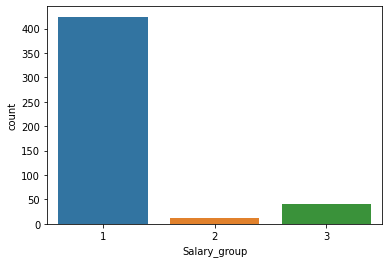

In [ ]:
sns.countplot(df['Salary_group'])

From the countplot, it can be observed that based on the grouping conditions being set, the individual categories of low, medium and high salaries are considered balanced. 

## **Part 3: Exploratory Data Analysis**

#**i. Feature correlations**

Data visualization was done after cleaning up null values. 


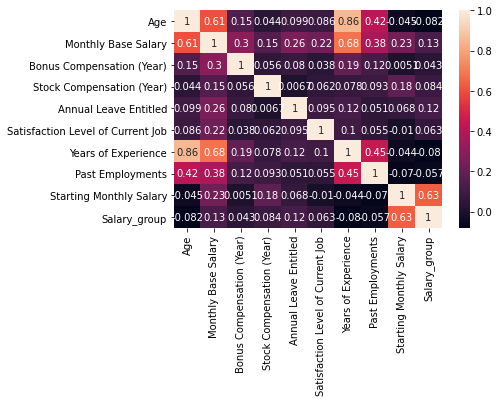

In [ ]:
sns.heatmap(df.corr() , annot=True)

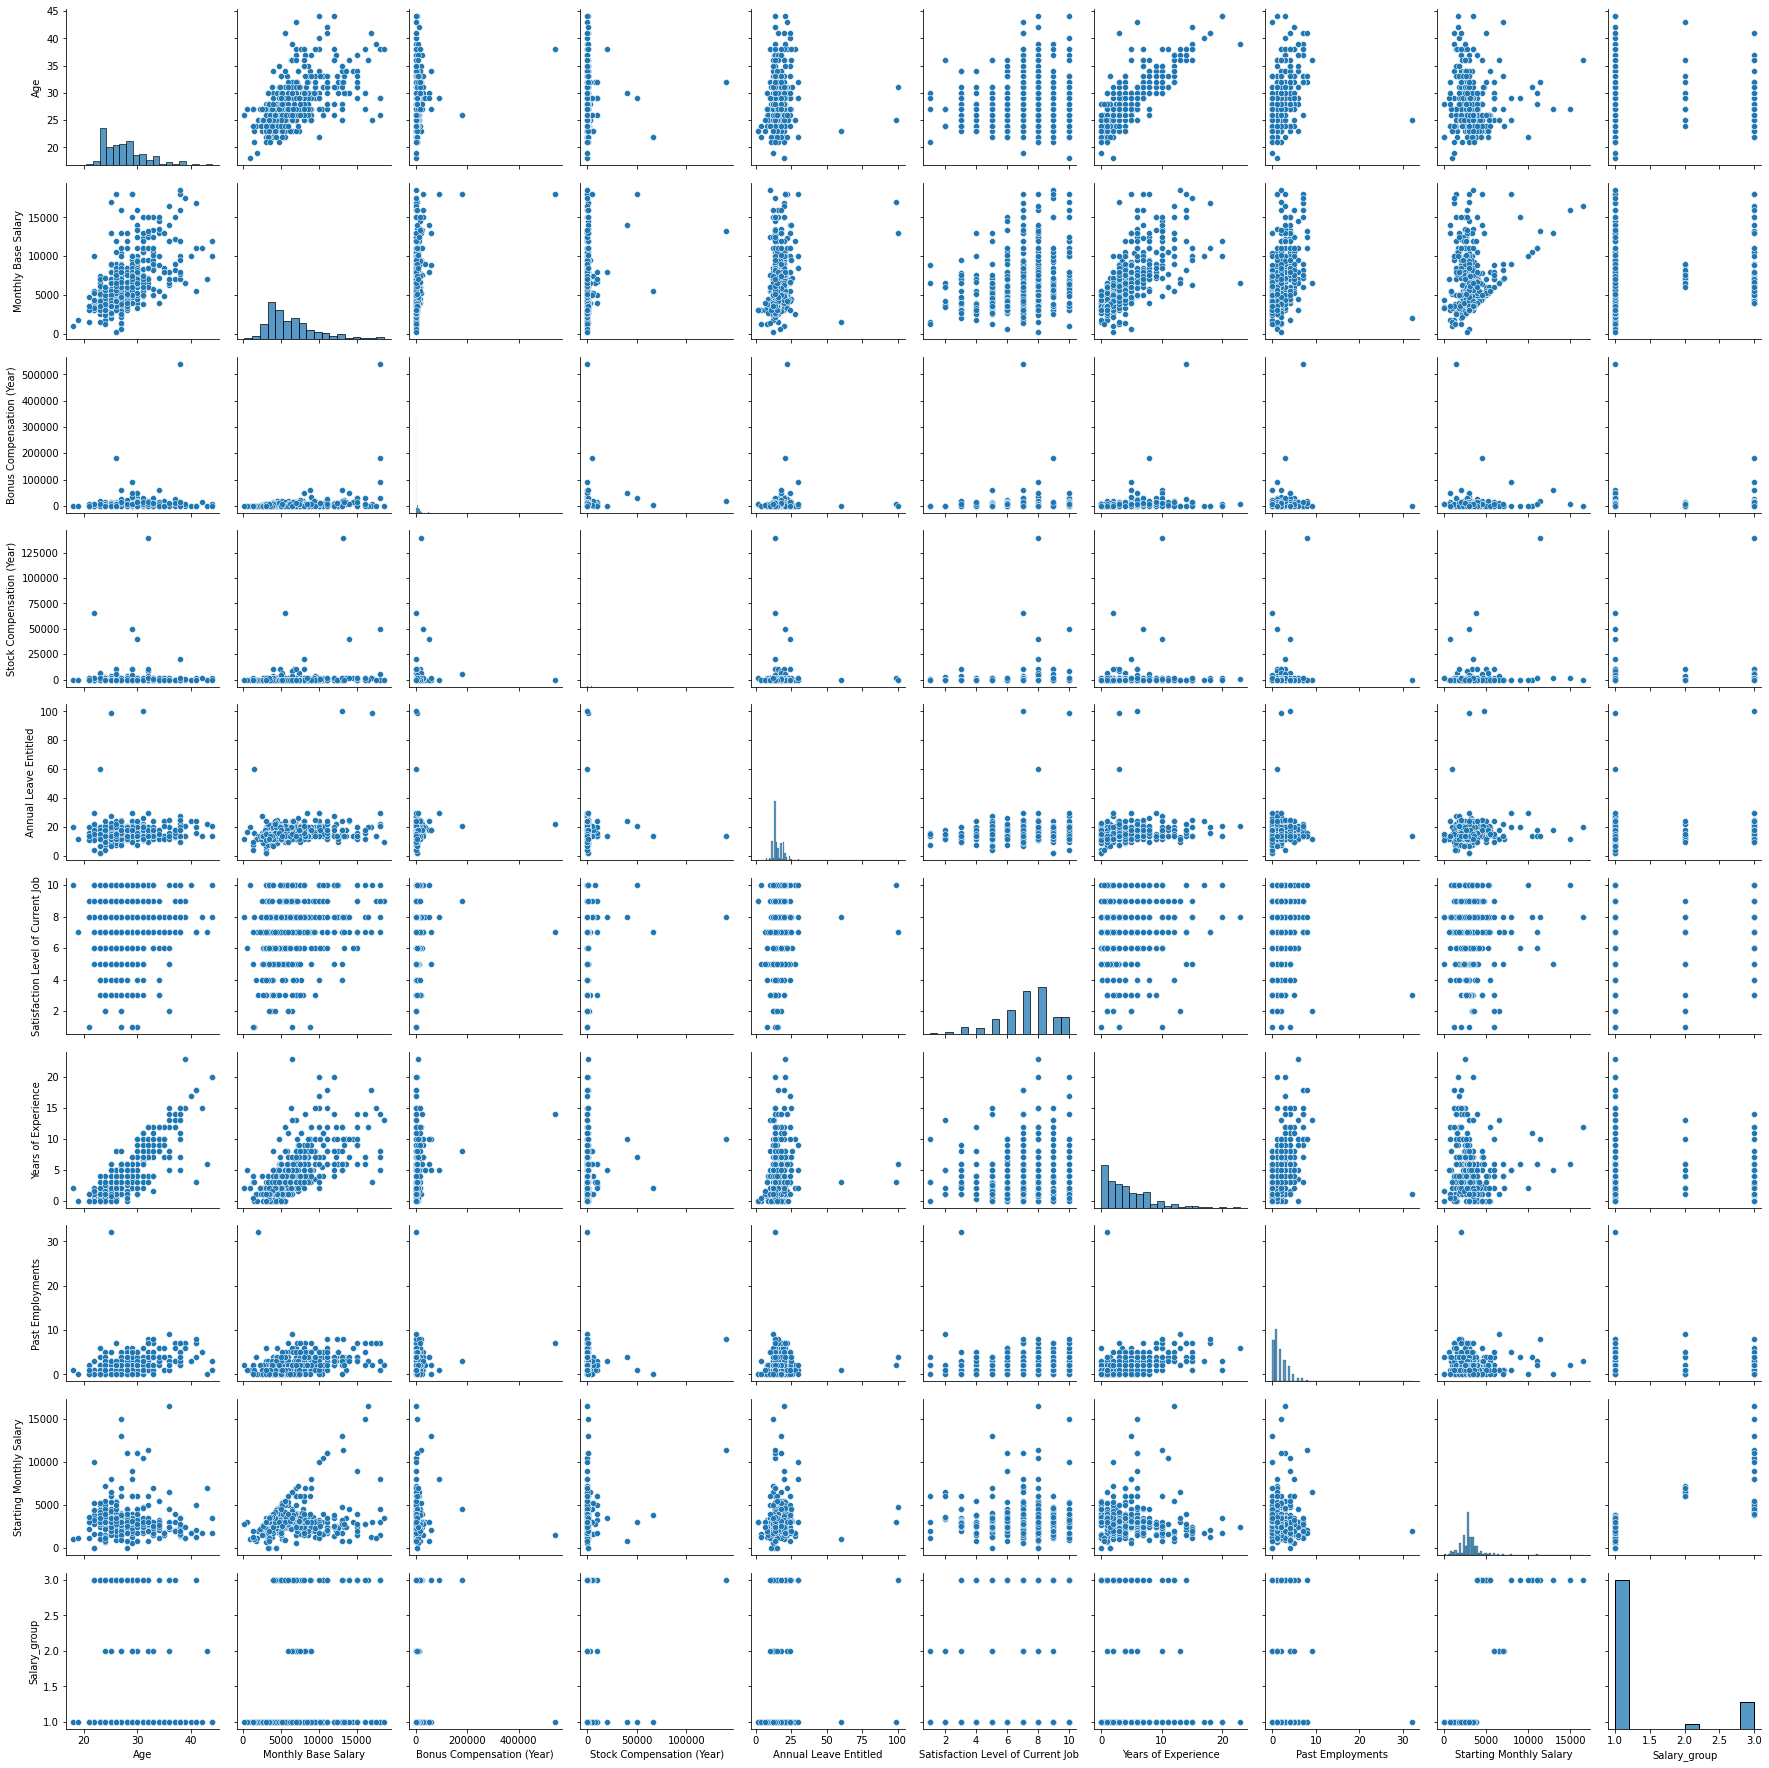

In [ ]:
sns.pairplot(df)

## **ii. Gender Distribution**

In [ ]:
def gender():
  labels = df['Gender'].unique().tolist()
  groups = df['Gender'].value_counts().tolist()

  figure1  = go.Figure(
    [
     go.Pie(labels=labels,
            values =groups)
            #marker_colors = colors)
    ]
  )

  figure1.update_layout(title='Gender Distribution')
  iplot(figure1)

In [ ]:
gender()

Based on the pie plot, about 88.2% of the respondents are male and about 11.4% are female. 

## **iii. Age Distribution**

In [ ]:
def age():
  values = df['Age'].values
  figure1 = ff.create_distplot([values] , ['Age'], histnorm='')
  figure1.update_layout(title = 'Age Distribution', xaxis_title = 'Age' , bargap =0.01)
  iplot(figure1)


In [ ]:
age()

The age distribution of the dataset shows a normal distribution curve with slight skew to the right of the distribution. Respondents are aged between 23 and 31 years with majority of them being 24 years old.

# **iv. Years of Experience**

In [ ]:
def experience():
  values = df['Years of Experience'].values
  figure1 = ff.create_distplot([values] , ['Experience'] ,  histnorm='')
  figure1.update_layout(title = 'Total Years of Experience', xaxis_title = 'Years of Experience', bargap = 0.01)
  iplot(figure1)

In [ ]:
experience()

In [ ]:
def location_state():
  figure1 = px.histogram(df , x= df['State of Residence'].value_counts().nlargest(10).index , color = df['State of Residence'].value_counts().nlargest(10).index)
  figure1.update_layout(title = 'Country Residence', bargap = 0.2)
  iplot(figure1)

def location_country():
  figure1 = px.histogram(df , x= df['Current Country of Residence'].value_counts().nlargest(10).index , color = df['Current Country of Residence'].value_counts().nlargest(10).index)
  figure1.update_layout(title = 'Country Residence', bargap = 0.2)
  iplot(figure1)

from plotly.subplots import make_subplots
def location():
  fig = make_subplots(1,2,subplot_titles=("Country of Residence", "State of Residence"))

  Country = go.Bar(x= df['Current Country of Residence'].value_counts().nlargest(10).index , y = df['Current Country of Residence'].value_counts().nlargest(10))
  State = go.Bar(x= df['State of Residence'].value_counts().nlargest(10).index , y =df['State of Residence'].value_counts().nlargest(10))
  fig.append_trace(Country,1,1)
  fig.append_trace(State,1,2)
  fig.update_layout(title="Geographical Location")
  fig.show()

In [ ]:
location()

From the bar plots below, it can be observed that majority of the respondents are local Malaysian which makes sense since this is a local based survey.Malaysians also chose to reside in Singapore, United States and etc perhaps due to the higher working standards. 

Considering that majority respondents are Malaysian, it is also worth exploring the states where most of them resides in. Selangor, Kuala Lumpur and Penang are the top three mostly occupied states within Malaysia.

## **Job Title**

In [ ]:
def job():  
  title = df['Job Title']
  cv = CountVectorizer(stop_words = 'english')
  title_df = pd.DataFrame(cv.fit_transform(title).todense(),
            columns = cv.get_feature_names())
  sns.barplot(x = title_df.sum().sort_values(ascending=False)[:20] , y = title_df.sum().sort_values(ascending=False).index[:20])

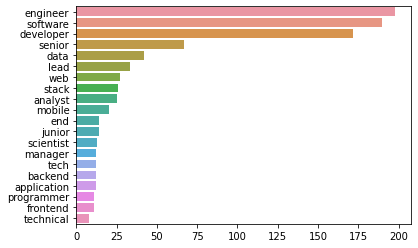

In [ ]:
job()

Terms like engineer, software and developer have huge occurences indicating that most IT professions are either software engineer or software developer.

# **Skill sets**

Having a guide as to what kind of programming languages or IT skills is mostly used by technology professionals can greatly help fresh graduates or career transitioners equip themselves in advance with the necessary skills. Plotting a wordcloud can be used to see some of the common skill sets used by different professionals.

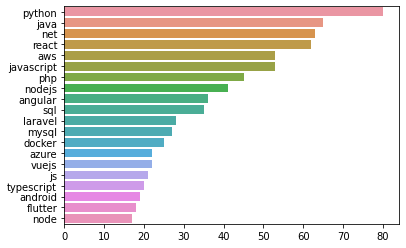

In [ ]:
def skills():
  skills = df['Technologies Used']
  cv =  CountVectorizer(stop_words = 'english')
  skills_df = pd.DataFrame(cv.fit_transform(skills).todense(),
                          columns = cv.get_feature_names())
  sns.barplot(x = skills_df.sum().sort_values(ascending=False)[:20] , y = skills_df.sum().sort_values(ascending=False).index[:20])

skills()

Python by far is the most popular skill being used with at least 15% of respondents used them for their work.

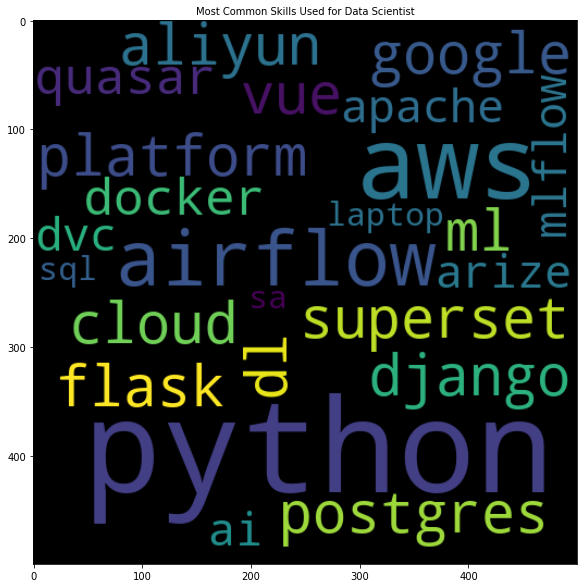

In [ ]:
#Only use this function when trying to separate skill sets 
'''
def split(col):
    temp_df = col.to_frame()
    options = []
    for i, val in col[col.notnull()].iteritems():
        for option in val.split(' '):
            if not option in temp_df.columns:
                options.append(option)
                temp_df[option]= False
            temp_df.at[i, option] = True
    return temp_df[options]

skills_df = split(df['Technologies Used'])
skills_df
'''
def plot_wordcloud(title):
    df_new = df[df['Job Title'] == title]
    plt.figure(figsize=(10,10))
    wc = WordCloud(max_words=100, width=500, height=500).generate(" ".join(df_new['Technologies Used']))
    plt.title("Most Common Skills Used for {}".format(title), fontsize=10)
    plt.imshow(wc, interpolation='bilinear')
    
plot_wordcloud('Data Scientist')

# **How does education level affect salary ?**

In [ ]:
edu_list = ['SPM' , 'Diploma' ,'Pre-University' , 'Bachelor Degree' , 'Masters Degree' , 'PhD']
df_edu = df[df['Highest Education Level'].isin(edu_list)]
df_edu['Highest Education Level'].value_counts()


def indexing(x):
  if x == 'SPM':
    return 'A'
  elif x == 'Diploma':
    return 'B'
  elif x == 'Pre-University':
    return 'C'
  elif x == 'Bachelor Degree':
    return 'D'
  elif x == 'Masters Degree':
    return 'E'
  else:
    return 'F'

#df_edu['Index'] = df_edu['Highest Education Level'].apply(indexing)


fig =  px.box(df_edu, x="Highest Education Level", y="Monthly Base Salary", color='Highest Education Level', category_orders={'Highest Education Level':['SPM','Pre-University' , 'Diploma', 'Bachelor Degree' , 'Masters Degree' , 'PhD']} , boxmode="overlay")
fig. update_layout(showlegend=False)
fig.show()


In [ ]:
fig = px.box(df_edu, x="Highest Education Level", y="Starting Monthly Salary", color = 'Highest Education Level',category_orders={'Highest Education Level':['SPM','Pre-University' , 'Diploma','Bachelor Degree' , 'Masters Degree' , 'PhD']} , boxmode="overlay")
fig. update_layout(showlegend=False)
fig.show()

# **How does geographical distribution affect salary ?**

In [ ]:
fig = px.box(df, x="State of Residence", y="Monthly Base Salary")
fig.show()

#**How does years of experience affect salary ?**

In [ ]:
fig = px.scatter(df, x = 'Years of Experience' ,y = 'Monthly Base Salary',  trendline="ols")
fig.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# **Part 4: Data Preparation**

For this project, the dataset has been prepared in three different ways to counter the low correlation between independent features and target feature in order to help improve model performance.

In [ ]:
max = df['Monthly Base Salary'].max()
df = df[df['Monthly Base Salary'] < max]
df

,Timestamp,Gender,Age,Nationality,Current Country of Residence,Current City of Residence,Name of Highest Degree Obtained,Name of School or University,Degree in Tech,Attended Bootcamp,Professional Certs,Name of Bootcamp Course,Name of Professional Certification(s),Job Title,Currency,Monthly Base Salary,Bonus Compensation (Year),Stock Compensation (Year),Annual Leave Entitled,Company Benefits,Technologies Used,Company Location,Company Industry,Company Size,Tech Team Size,What's the name of your company? [Optional],Satisfaction Level of Current Job,Years of Experience,Past Employments,Starting Monthly Salary,Indicate in 3-character currency code for starting monthly salary,Highest Education Level,State of Residence,Salary_group
1,26/7/2021 20:04,Male,28,Malaysian,Malaysia,Tampin,Bachelor of Computer Science,Taruc,Yes,No,No,NaN,NaN,Front end team lead,MYR,4500,6198.469869,1247.951114,18,"Vacation Personal Days , Remote Work",angular nestjs laravel wordpress nextjs,"Johor, Malaysia","Transport, Logistics",1-10,2 - 10,NaN,8,5.0,6.0,4500.0,NaN,Pre-University,Negeri Sembilan,3
2,26/7/2021 20:05,Male,23,Malaysian,Malaysia,Kuala Lumpur,Bachelor of Computer Science,Monash University,Yes,No,No,NaN,NaN,Associate Developer,MYR,5000,0.000000,0.000000,16,"Health Insurance , Life Insurance , Paternity ...",configura magic,"Kuala Lumpur, Malaysia",Space planning,201-1000,51 - 200,Configura,7,0.0,0.0,5000.0,NaN,Bachelor Degree,Kuala Lumpur,3
3,26/7/2021 20:05,Female,25,Malaysian,Malaysia,Kuala Lumpur,Bachelor of Computer Science,UTAR,Yes,No,Yes,NaN,"AWS SA, ITIL v4",Supporr Engineer,MYR,17000,6198.469869,1247.951114,99,"Sick Time Unlimited , Free Drinks , Learning D...",terminal zendesk slack,"California, United States",Business,1001-10000,11 - 50,NaN,10,3.0,2.0,3000.0,NaN,Bachelor Degree,Selangor,1
4,26/7/2021 20:05,Male,22,Malaysian,Malaysia,Puchong,Bachelor of Software System Development,Tunku Abdul Rahman University College (TAR UC),Yes,No,No,NaN,NaN,Application Engineer,MYR,4000,0.000000,0.000000,16,"Life Insurance , Company Laptop",.net,Petaling Jaya,Business,201-1000,2 - 10,NaN,8,1.0,0.0,4000.0,NaN,Bachelor Degree,Selangor,1
6,26/7/2021 20:07,Male,31,Malaysian,Malaysia,KL,Bachelor of Computer Sciene,UTeM,Yes,No,No,NaN,NaN,Senior Frontend Developer,MYR,9500,9500.000000,0.000000,14,"Life Insurance , Dental Insurance , Transport ...",react j redux,KL,Communication,11-50,0 - 1,NaN,9,7.0,3.0,2800.0,NaN,Bachelor Degree,Kuala Lumpur,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,18/8/2021 9:55,Male,26,Malaysian,Malaysia,PJ,Bachelor of Information Technology,TARUC,Yes,No,Yes,NaN,CCNA,Software Engineer,MYR,6500,0.000000,0.000000,15,Company Laptop,.net core mysql,"Kuala Lumpur, Malaysia",Business,11-50,2 - 10,NaN,5,4.0,2.0,3500.0,MYR,Bachelor Degree,Selangor,1
532,18/8/2021 13:47,Male,36,Malaysian,Malaysia,Shah Alam,Bachelor of Computer Science Software Engineering,UTM,Yes,No,No,NaN,NaN,Senior Software Engineer,MYR,7000,10000.000000,0.000000,14,Employee Assistance Program,ruby rail ruby postgresql bash shell,Selangor,Communication,1-10,2 - 10,DNSVault,6,7.0,2.0,2500.0,MYR,Bachelor Degree,Selangor,1
533,21/8/2021 17:36,Male,21,Malaysian,Malaysia,Kepong,Bachelor of Computer Science,UTAR,Yes,Yes,Yes,NaN,CCNA,Software Engineer,MYR,3600,0.000000,0.000000,14,"Dental Claim , Vacation Personal Days , Free S...",python node.js javascripts mysql etc,"Kuala Lumpur, Malaysia","Media, Creative Industries",11-50,2 - 10,NaN,8,1.0,1.0,3600.0,MYR,Bachelor Degree,Kuala Lumpur,1
534,22/8/2021 8:22,Male,23,Malaysian,Malaysia,Pj,Bachelor of CompE,UofM,Yes,No,No,NaN,NaN,Software Developer,MYR,3500,6198.469869,1247.951114,12,Health Insurance,c #,PJ,Business,11-50,2 - 10,NaN,6,1.0,0.0,3500.0,MYR,Bachelor Degree,Selangor,1


In [ ]:
salary_df = df.copy()
salary_df['Gender'] = salary_df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
salary_df['Degree in Tech'] = salary_df['Degree in Tech'].apply(lambda x: 1 if x == 'Yes' else 0)
salary_df['Attended Bootcamp'] = salary_df['Attended Bootcamp'].apply(lambda x: 1 if x == 'Yes' else 0)
salary_df['Professional Certs'] = salary_df['Professional Certs'].apply(lambda x: 1 if x == 'Yes' else 0)


In [ ]:
#industry = pd.Categorical(df['Company Industry']).codes
#tech_size = pd.Categorical(salary_df['Tech Team Size']).codes 
#job = pd.Categorical(df['Professions']).codes
#company_size = pd.Categorical(salary_df['Company Size']).codes
edu = pd.Categorical(df['Highest Education Level']).codes
country = pd.Categorical(df['Current Country of Residence']).codes
state = pd.Categorical(df['State of Residence']).codes


#salary_df['Company Industry'] = industry
#salary_df["Tech Team Size"] = tech_size
#salary_df["Company Size"] = company_size
#salary_df['Professions'] = job
salary_df['State of Residence'] = state
salary_df['Highest Education Level'] = edu

## **A. Data for Salary Group Prediction : Using multiple numerical features**

In [ ]:
#cond1 = (salary_df['Starting Monthly Salary'] > 0.01) & (salary_df['Starting Monthly Salary'] < 62250)
#cond2 = (salary_df['Monthly Base Salary'] > 1 ) & (salary_df['Monthly Base Salary'] < 24000)
#cond3 = (salary_df['Annual Leave Entitled'] > 1) & (salary_df['Annual Leave Entitled'] < 105)
#salary_df = salary_df[cond1 & cond2 & cond3]
#cond4 = (salary_df['Bonus Compensation (Year)'] < 540000) 
#cond5 = (salary_df['Stock Compensation (Year)'] < 140000) 

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='not minority')
x = salary_df[['Years of Experience','Past Employments','Degree in Tech']]
y = salary_df['Salary_group']

#x_train, y_train = sm.fit_sample(x_train, y_train)

x, y = sm.fit_sample(x, y)
x_train, x_test,y_train, y_test = train_test_split(x ,y, test_size = 0.2 ,random_state = 7)





#x_test, y_test = sm.fit_sample(x_test, y_test)
sc = StandardScaler() 
  
scaled_x_train = sc.fit_transform(x_train) 
#scaled_y_train = sc.transform(y_train)
scaled_x_test = sc.transform(x_test) 

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [ ]:
print(x_test.shape , y_test.shape)

(160, 3) (160,)


# **B. Data for Salary Group Prediction : Using single numerical feature**

In [ ]:
salary_df1 = salary_df.copy()

In [ ]:
x = salary_df1[['Years of Experience']]
y = np.asarray(salary_df1['Salary_group'])

x_train, x_test, y_train ,y_test = train_test_split(x ,y, test_size = 0.2 ,random_state = 7)

sc = StandardScaler() 
  
scaled_x_train = sc.fit_transform(x_train) 
scaled_x_test = sc.transform(x_test) 

# **C. Data for Salary Group Prediction : Using text features**

In [ ]:
cv = CountVectorizer()
title_df = pd.DataFrame(cv.fit_transform(df['Job Title']).todense(),
                          columns = cv.get_feature_names())
skills_df = pd.DataFrame(cv.fit_transform(df['Technologies Used']).todense(),
                          columns = cv.get_feature_names())


text_df = pd.concat([title_df,skills_df], axis=1)
text_df.head()

,advanced,ai,analysis,analyst,analytics,android,app,application,applications,apps,architect,assistant,associate,assurance,automation,back,backed,backend,blockchain,business,chief,cloud,consultant,consultants,consulting,control,coordinator,cto,cybersecurity,data,dba,de,deep,delivery,design,dev,develoepr,develoer,developer,developers,...,tailwindcss,talend,taurus,team,technology,telco,tensorflow,terminal,terraform,three,tibco,tool,trello,typescript,understand,unix,vb,vision,visual,vm,vmware,vscode,vue,vuejs,wa,web,webflow,weblogic,website,websocket,wifi,window,wordpress,workbench,workday,xampp,xcode,zend,zendesk,zeplin
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np.asmatrix(text_df), df['Salary_group'], test_size=0.2,
                                                    random_state=7)

In [ ]:
scaled_x_train = StandardScaler().fit_transform(x_train)
scaled_x_test = StandardScaler().fit_transform(x_test)

## **D. Data for Job Recommendation**

In [ ]:
recommend_df = df.copy()

In [ ]:
tags = recommend_df.groupby('Job Title')['Technologies Used'].apply(set).apply(list)
recommend_df['tags'] = df['Job Title'].apply(lambda x: ' '.join(tags[x]))

In [ ]:
tfidf = TfidfVectorizer(stop_words = 'english')
matrix = tfidf.fit_transform(recommend_df['tags'])

In [ ]:
similarities = cosine_similarity(matrix, matrix)
print(similarities)

[[1.         0.         0.         ... 0.06398069 0.12779317 0.06398069]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.01176434 0.         0.01176434]
 ...
 [0.06398069 0.         0.01176434 ... 1.         0.40934005 1.        ]
 [0.12779317 0.         0.         ... 0.40934005 1.         0.40934005]
 [0.06398069 0.         0.01176434 ... 1.         0.40934005 1.        ]]


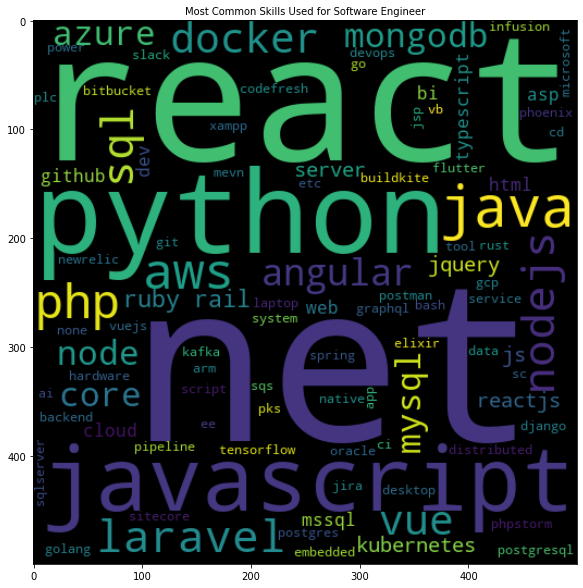

In [ ]:
def get_title_id(title):
    index = recommend_df[recommend_df['Job Title'] == title].index.to_list()
    #print(index)
    if len(index) == 0 | len(index) < 3:
        return index[0]
    else:
        return index[1]
    
def get_title(title_id):
    title = recommend_df.iloc[title_id]['Job Title']
    return title


def similar_job(title):
    title_id = get_title_id(title)
    
    if (title_id is not None):
        temp = list(enumerate(similarities[title_id]))
        job_similarities = sorted(temp, key = lambda x: x[1], reverse=True)
        
        similar_job = job_similarities[1:6]
        
            
        similar_job = list(map(lambda x: (get_title(x[0]), round(x[1], 2)), job_similarities))
        similar_job_df = pd.DataFrame(similar_job, columns = ['Job Title' , 'Similarity']).head(10)
        
        return similar_job_df.drop_duplicates()

def recommend_job_skills(title):
    job = similar_job(title)
    for j in job['Job Title'].tolist()[0:3]:
      plot_wordcloud(j)

recommend_job_skills('Programmer')

        

## **Part 5: ML Algorithm Modelling**

For this classification problem, different supervised learning algorithms were used to predict the different monthly salary groupings. GridSearchCV was used to search and fine tune the model's hyperparameters to be fitted for the models to further improve on model performance metrics.

## **A. Support Vector Machine**

In [ ]:
from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
svm = GridSearchCV(SVC(), param_grid, verbose = 0)
  
# fitting the model for grid search
svm.fit(scaled_x_train, y_train)


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
accuracy_score(y_test , svm.predict(scaled_x_test))

0.8854166666666666

In [ ]:
f1_score(y_test , svm.predict(scaled_x_test), average='weighted')

0.8316068139963169

In [ ]:
cross_val_score(SVC(), scaled_x_train, y_train,cv= KFold(n_splits=10)).mean()

0.8921052631578947

#**B. Decision Tree Classifier**

In [ ]:
param_grid = {'criterion': ['gini', 'entropy'], 
              'max_depth': range(1,10),
              #'min_samples_split': range(1,10),
              'min_samples_leaf': range(1,5)} 

In [ ]:
tr = GridSearchCV(DecisionTreeClassifier(), param_grid,cv = KFold(n_splits = 3), n_jobs=-1)
tr.fit(scaled_x_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             para

In [ ]:
accuracy_score(y_test , tr.predict(scaled_x_test))

0.8854166666666666

In [ ]:
precision_score(y_test , tr.predict(scaled_x_test), average = 'weighted')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



0.783962673611111

In [ ]:
cm=confusion_matrix(y_test,tr.predict(scaled_x_test))
print(cm)

[[85  0  0]
 [ 2  0  0]
 [ 9  0  0]]


In [ ]:
cross_val_score(DecisionTreeClassifier(), scaled_x_train, y_train,cv= KFold(n_splits=10)).mean()

0.8210526315789473

## **C. Gaussian Naive Bayes**

In [ ]:
nb = GaussianNB()
nb.fit(scaled_x_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
accuracy_score(y_test , nb.predict(scaled_x_test))

0.875

In [ ]:
cross_val_score(GaussianNB(), scaled_x_train, y_train).mean()

0.6342105263157894

In [ ]:
precision_score(y_test , nb.predict(scaled_x_test), average='micro')

0.875

In [ ]:
cm=confusion_matrix(y_test,svm.predict(scaled_x_test))
cm

array([[44,  0, 21],
       [ 4,  0,  0],
       [28,  0, 63]])

#**D. Random Forest Classifier**

In [ ]:
model_params = {
    'n_estimators': [50, 150, 250],
    #'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [2, 4, 6]
}
rf = GridSearchCV(RandomForestClassifier(), model_params, cv= KFold(n_splits=5))
                  
rf.fit(scaled_x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_s

In [ ]:
accuracy_score(y_test ,rf.predict(scaled_x_test))

0.8854166666666666

In [ ]:
precision_score(y_test ,rf.predict(scaled_x_test), average='weighted')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



0.783962673611111

In [ ]:
cross_val_score(RandomForestClassifier(), scaled_x_train, y_train,cv= KFold(n_splits=10)).mean()

0.881578947368421

#**E. K-Nearest Neighbor**

In [ ]:
knn_params = {
    'n_neighbors': [3,5,11,19],
    'weights' : ['uniform' , 'distance'],
    'metric': ['euclidean' , 'manhattan']
}
kn = GridSearchCV(KNeighborsClassifier() , knn_params , cv = KFold(n_splits = 5), n_jobs=-1)
kn.fit(scaled_x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 11, 19],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
accuracy_score(y_test ,kn.predict(scaled_x_test))

0.8854166666666666

In [ ]:
cross_val_score(KNeighborsClassifier(), scaled_x_train, y_train).mean()

0.8894736842105264

#**F. AdaBoost Classifier**

In [ ]:
ada_param = {
    'n_estimators' : [100,200,300],
    'learning_rate' : [0.1, 1,10]
    
}
ab = GridSearchCV(AdaBoostClassifier(), ada_param , cv = KFold(n_splits = 5))
ab.fit(scaled_x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.1, 1, 10],
                         'n_estimators': [100, 200, 300]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
accuracy_score(y_test ,ab.predict(scaled_x_test))

0.875

In [ ]:
precision_score(y_test ,ab.predict(scaled_x_test), average='weighted')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



0.7828947368421053

In [ ]:
cross_val_score(AdaBoostClassifier(), scaled_x_train, y_train,cv= KFold(n_splits=10))

array([0.84210526, 0.92105263, 0.84210526, 0.86842105, 0.84210526,
       0.76315789, 0.89473684, 0.73684211, 0.81578947, 0.78947368])

#**G. Multi Layer Perceptron**

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(8,8,3))
mlp.fit(scaled_x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(8, 8, 3), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
accuracy_score(y_test ,mlp.predict(scaled_x_test))

0.8645833333333334

In [ ]:
precision_score(y_test , mlp.predict(scaled_x_test), average = 'weighted')

0.7818040780141845

#**Part 6: Model Performance Comparison**

In [ ]:
algos = ['Naives Bayes' , 'Support Vector Machine', 'K Nearest Neighbors','Decision Tree Classifier' , 'Random Forest Classifier' , 'AdaBoost Classifier' ,'Multi Layer Perceptron']
fit_model = [model.fit(scaled_x_train , y_train) for model in [nb , svm, kn , tr ,rf,ab , mlp]]

def model_performance():
  acc = []
  prec = []
  recall = []
  f1 = []
  for model in fit_model:
    prediction = model.predict(scaled_x_test) 
    A = accuracy_score(y_test,prediction) * 100
    P = precision_score(y_test, prediction, average='weighted') * 100
    R = recall_score(y_test,prediction,average='weighted') * 100
    F = f1_score(y_test,prediction,average='weighted') * 100
    acc.append(A)
    prec.append(P)
    recall.append(R)
    f1.append(F)
  return pd.DataFrame(zip(algos , acc , prec, recall, f1) , columns = ['Algorithm' , 'Accuracy' , 'Precision' , 'Recall' , 'F1'])

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



In [ ]:
model_performance()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/pytho

,Algorithm,Accuracy,Precision,Recall,F1
0,Naives Bayes,87.500000,78.289474,87.500000,82.638889
1,Support Vector Machine,88.541667,78.396267,88.541667,83.160681
2,K Nearest Neighbors,88.541667,78.396267,88.541667,83.160681
3,Decision Tree Classifier,88.541667,78.396267,88.541667,83.160681
4,Random Forest Classifier,88.541667,78.396267,88.541667,83.160681
5,AdaBoost Classifier,87.500000,78.289474,87.500000,82.638889
6,Multi Layer Perceptron,70.833333,81.093037,70.833333,75.360408


In [ ]:
def performance(metrics):
  colors = ['#0077B6', '#00B4D8', '#90E0EF', '#CAF0F8', '#03045E']
  figure1 = px.bar(model_performance() , orientation = 'h', x = metrics , y='Algorithm' ,color='Algorithm' , color_discrete_sequence= colors)
  figure1 = figure1.update_layout(title=metrics, width = 1000, height=500)
  iplot(figure1)

In [ ]:
performance('Accuracy')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/pytho

In [ ]:
performance('Precision')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/pytho

In [ ]:
performance('F1')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/pytho

In [ ]:
performance('Recall')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/pytho

In [ ]:
def plot_cm(model):
  
    label_aux = plt.subplot()
    prediction = model.predict(scaled_x_test)
    cm = confusion_matrix(y_test,prediction)
    cm = pd.DataFrame(cm, index = ['Low' , 'Medium' , 'High'], columns = ['Low' , 'Medium' , 'High'])
    #cm = pd.DataFrame(cm_svm, index = df['Salary_group'].unique(), columns = df['Salary_group'].unique())#
    sns.heatmap(cm,annot=True,fmt="d", cbar=True)
    label_aux.set_xlabel('Predicted Value');label_aux.set_ylabel('True Value');

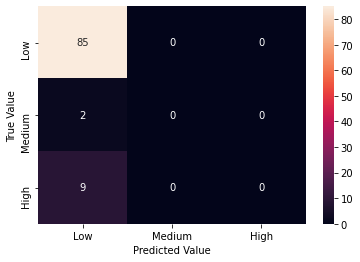

In [ ]:
plot_cm(tr)

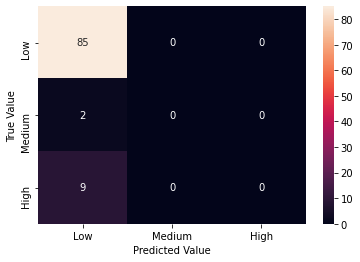

In [ ]:
plot_cm(rf)

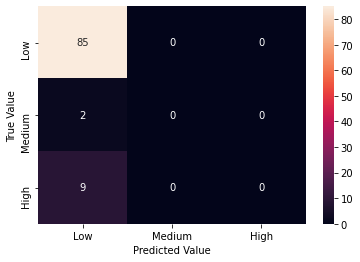

In [ ]:
plot_cm(kn)